# DirecTV Introduction to JumpStart - Text to Image Demonstration

***
Welcome to Amazon [SageMaker JumpStart](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html)! You can use JumpStart to solve many Machine Learning tasks through one-click in SageMaker Studio, or through [SageMaker JumpStart API](https://sagemaker.readthedocs.io/en/stable/overview.html#use-prebuilt-models-with-sagemaker-jumpstart).  In this demo notebook, we demonstrate how to use the JumpStart API to generate images from text using state-of-the-art Stable Diffusion models. Furthermore, we show how to fine-tune the model to your dataset.

Stable Diffusion is a text-to-image model that enables you to create photorealistic images from just a text prompt. A diffusion model trains by learning to remove noise that was added to a real image. This de-noising process generates a realistic image. These models can also generate images from text alone by conditioning the generation process on the text. For instance, Stable Diffusion is a latent diffusion where the model learns to recognize shapes in a pure noise image and gradually brings these shapes into focus if the shapes match the words in the input text.

Training and deploying large models and running inference on models such as Stable Diffusion is often challenging and include issues such as cuda out of memory, payload size limit exceeded and so on.  JumpStart simplifies this process by providing ready-to-use scripts that have been robustly tested. Furthermore, it provides guidance on each step of the process including the recommended instance types, how to select parameters to guide image generation process, prompt engineering etc. Moreover, you can deploy and run inference on any of the 80+ Diffusion models from JumpStart without having to write any piece of your own code.

In the first part of this notebook, you will learn how to use JumpStart to generate highly realistic and artistic images of any subject, object, environment orscene. This may be as simple as an image of a cute dog or as detailed as a hyper-realistic image of a beautifully decoraded cozy kitchen by pixer in the style of Greg Rutkowski with dramatic sunset lighting and long shadows with cinematic atmosphere. This can be used to design products and build catalogs for ecommerce business needs or to generate realistic art pieces or stock images.

In the second part of this notebook, you will learn how to use JumpStart to fine-tune the Stable Diffusion model to your dataset. This can be useful when creating art, logos, custom designs, NFTs, and so on, or fun stuff such as generating custom AI images of your pets or avatars of yourself.


Model license: By using this model, you agree to the [CreativeML Open RAIL-M++ license](https://huggingface.co/stabilityai/stable-diffusion-2/blob/main/LICENSE-MODEL).

***

Note: This notebook was tested on ml.t3.medium instance in Amazon SageMaker Studio with Python 3 (Data Science) kernel and in Amazon SageMaker Notebook instance with conda_python3 kernel.

Note: To deploy the pre-trained or fine-tuned model, you can use `ml.p3.2xlarge` or `ml.g4dn.2xlarge` instance types. If `ml.g5.2xlarge` is available in your region, we recommend using that instance type for deployment. For fine-tuning the model on your dataset, you need `ml.g4dn.2xlarge` instance type available in your account.

### 1. Set Up

***

Before executing the notebook, there are some initial steps required for set up. This notebook requires ipywidgets and latest version of sagemaker.


***

In [52]:
!pip install ipywidgets==7.0.0 --quiet
!pip install --upgrade sagemaker

import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

from ipywidgets import Dropdown
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models

# Retrieves all Text-to-Image generation models.
filter_value = "task == txt2img"
txt2img_models = list_jumpstart_models(filter=filter_value)

# display the model-ids in a dropdown to select a model for inference.
model_dropdown = Dropdown(
    options=txt2img_models,
    value="model-txt2img-stabilityai-stable-diffusion-v2-1-base",
    description="Select a model",
    style={"description_width": "initial"},
    layout={"width": "max-content"},
)
display(model_dropdown)

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


A Jupyter Widget

In [53]:
# model_version="*" fetches the latest version of the model
model_id, model_version = model_dropdown.value, "*"

### Deploy an Endpoint

***


### This may take up to 10 minutes. Please do not kill the kernel while you wait.

While you wait, you can checkout the [Generate images from text with the stable diffusion model on Amazon SageMaker JumpStart](https://aws.amazon.com/blogs/machine-learning/generate-images-from-text-with-the-stable-diffusion-model-on-amazon-sagemaker-jumpstart/) blog to learn more about Stable Diffusion model and JumpStart.


***

In [ ]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters, instance_types
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base


endpoint_name = name_from_base(f"jumpstart-example-infer-{model_id}")

# Please use ml.g5.24xlarge instance type if it is available in your region. ml.g5.24xlarge has 24GB GPU compared to 16GB in ml.p3.2xlarge and supports generation of larger and better quality images.
inference_instance_type = instance_types.retrieve_default(
    region=None,
    model_id=model_id,
    model_version=model_version,
    scope="inference"
)

# Retrieve the inference docker container uri. This is the base HuggingFace container image for the default model above.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)

# Retrieve the model uri. This includes the pre-trained model and parameters as well as the inference scripts.
# This includes all dependencies and scripts for model loading, inference handling etc..
model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="inference"
)

# To increase the maximum response size (in bytes) from the endpoint.
env = {
    "MMS_MAX_RESPONSE_SIZE": "20000000",
}

# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    model_data=model_uri,
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
    env=env,
)

# Deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class,
# for being able to run inference through the sagemaker API.
model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
)

import matplotlib.pyplot as plt
import numpy as np


def query(model_predictor, text):
    """Query the model predictor."""

    encoded_text = text.encode("utf-8")

    query_response = model_predictor.predict(
        encoded_text,
        {
            "ContentType": "application/x-text",
            "Accept": "application/json",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return generated image and the prompt"""

    response_dict = json.loads(query_response)
    return response_dict["generated_image"], response_dict["prompt"]


def display_img_and_prompt(img, prmpt):
    """Display hallucinated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

-----------!

### 2.3. Query endpoint and parse response

***
Input to the endpoint is any string of text converted to json and encoded in `utf-8` format. Output of the endpoint is a `json` with generated text.

***

***
Below, we put in some example input text. You can put in any text and the model predicts the image corresponding to that text.

***


---------------------------

Enter text below for image generation:



 A croissant sitting on top of a yellow plate, a portrait, trending on unsplash, sitting on a mocha-coloured table, magazine, woodfired, bakery, great composition, amber 


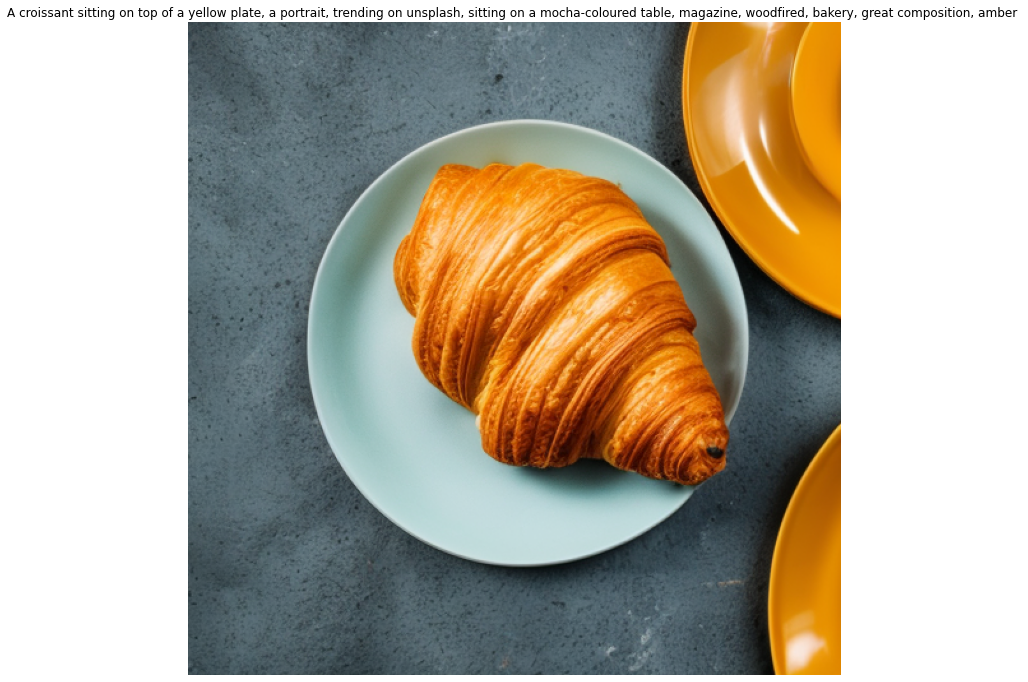

In [60]:
text = "woman on elephant in paris by dali"
print("\n---------------------------\n")
print("Enter text below for image generation:\n")
mytext=input()
query_response = query(model_predictor, mytext)
img, prmpt = parse_response(query_response)
display_img_and_prompt(img, prmpt)

### 2.8. Clean up the endpoint

## Always run this step when you are finished

In [61]:
# Delete the SageMaker endpoint
model_predictor.delete_model()
model_predictor.delete_endpoint()